In [1]:
import shutil
from collections import defaultdict
from pathlib import Path
from typing import Callable

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib.axes import Axes

import utils

In [2]:
sns.set_theme(style='dark')
plt.rcParams["figure.titlesize"] = 20

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# ---- Path

DATA_DIR = Path('data')
DATA_VIDEOS = DATA_DIR / 'videos'
DATA_IMAGES = DATA_DIR / 'images'
DATA_LABELS = DATA_DIR / 'labels'
DATA_CROP = DATA_DIR / 'crop'

DIST_DIR = Path('dist')
DIST_LABELS = DIST_DIR / 'labels'
DIST_LABELS_HAND = DIST_LABELS / 'hand'
DIST_LABELS_YOLO = DIST_LABELS / 'yolo'
DIST_MODELS = DIST_DIR / 'models'

# ---- Image

IMG_SIZE_ORIG = 720
IMG_SIZE_YOLO = 416

DATA_IMAGES_ORIG = DATA_IMAGES / str(IMG_SIZE_ORIG)
DATA_IMAGES_YOLO = DATA_IMAGES / str(IMG_SIZE_YOLO)

# ---- Domain

MOBS = ['zombie', 'skeleton', 'spider', 'creeper', 'enderman', 'slime']
BIOMES = [
    'plains_0', 'plains_1',
    'savanna_0', 'savanna_1',
    'desert_0', 'desert_1',
    'snowy_0', 'snowy_1',
    'cave',
]

# ---- Utils

RANDOM = np.random.default_rng(0)
COLOR_PALETTE = utils.ColorPalette([
    (8, 247, 254),
    (254, 83, 187),
    (238, 66, 102),
    (255, 210, 63),
    (59, 206, 172),
    (14, 173, 105),
], MOBS)

# ---- Mosaic

MOSAIC_3 = utils.Mosaic("""
    AAB
    AAC
""")

MOSAIC_13 = utils.Mosaic("""
    ABEEFF
    CDEEFF
    GGGGHH
    GGGGHH
    GGGGKL
    MMNNPP
    MMNNPP
""")

MOSAIC_27 = utils.Mosaic("""
    AABBCDEFGH
    AABBIIIIII
    JJJJIIIIII
    JJJJIIIIII
    JJJJIIIIII
    JJJJIIIIII
    KKLMIIIIII
    KKNOPPPQQR
    XYWWPPPQQS
    Z0WWPPPTUV
""")

# Создание датасета

## Сбор данных

In [11]:
def video2frames(path: Path, save_dir: Path, name: str):
    vidcap = cv2.VideoCapture(str(path))
    ok, img = vidcap.read()
    cnt = 0
    while ok:
        cv2.imwrite(str(save_dir / f'{name}_{cnt:02}.jpg'), img[:, 75:img.shape[0] + 75])
        cnt += 1
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (cnt * 500))
        ok, img = vidcap.read()


def create_images_from_videos(video_path: Path, image_path: Path):
    """Создает картинки для всех групп мобов из соответствующих видео"""
    for i, mob in enumerate(tqdm(MOBS)):
        mob_ = f'{i:02}_{mob}'
        for j, biome in enumerate(tqdm(BIOMES)):
            biome_ = f'{j:02}_{biome}'
            video2frames(video_path / mob_ / f'{biome_}.mkv', image_path, f'{mob_}_{biome_}')


In [21]:
create_images_from_videos(DATA_VIDEOS, DATA_IMAGES_ORIG)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

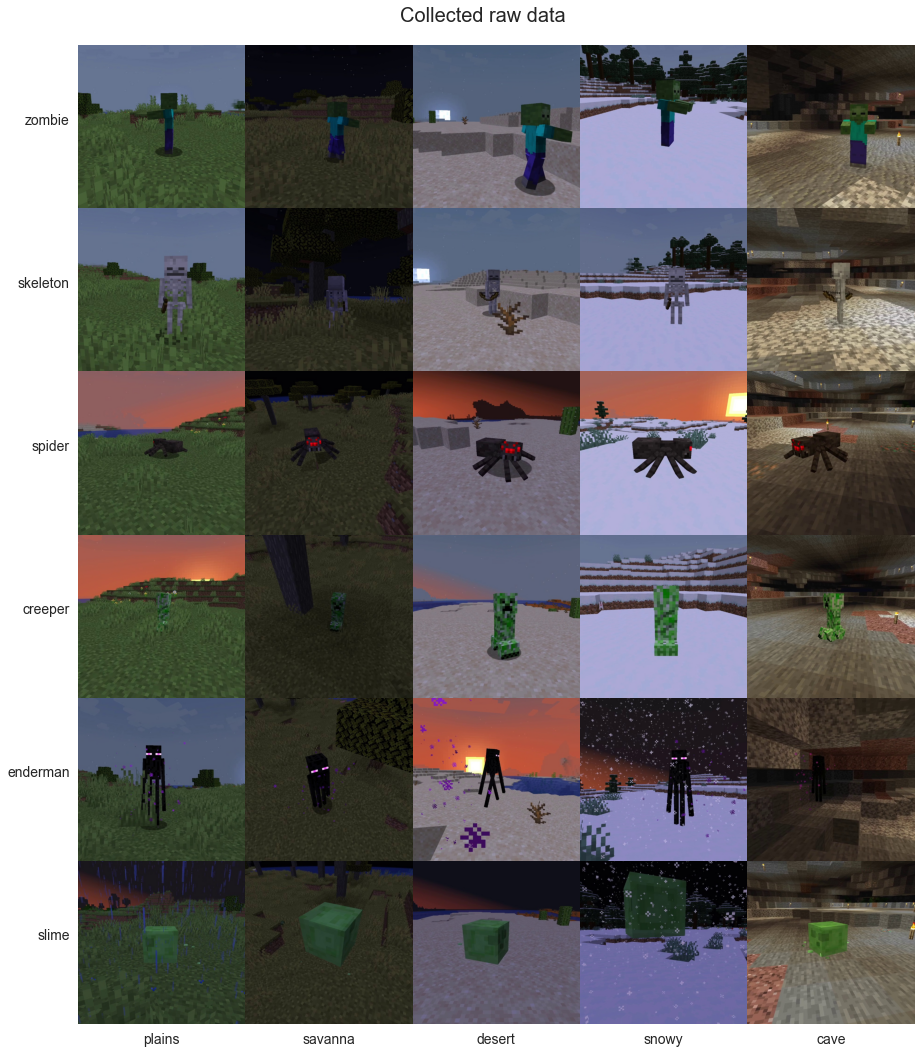

In [94]:
biomes_sample = [
    '00_plains_0_01.jpg',
    '03_savanna_1_25.jpg',
    '04_desert_0_12.jpg',
    '06_snowy_0_01.jpg',
    '08_cave_08.jpg'
]
biomes_sample_names = [i.split('_')[1] for i in biomes_sample]
images_sample = []
for i, mob in enumerate(MOBS):
    mob_ = f'{i:02}_{mob}'
    for biome in biomes_sample:
        path = DATA_IMAGES_ORIG / f'{mob_}_{biome}'
        images_sample.append(utils.Image.open(path).data)

nrows, ncols = 6, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15 / (ncols / nrows)))
fig.subplots_adjust(hspace=0.00, wspace=0.00)
fig.suptitle('Collected raw data', y=0.91)
for i, image in enumerate(images_sample):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col]
    utils.reset_axes(ax)

    if col == 0:
        ax.set_ylabel(MOBS[row], rotation=0, labelpad=8, horizontalalignment='right', size=14)
    if row == nrows - 1:
        ax.set_xlabel(biomes_sample_names[col], labelpad=8, size=14)

    ax.imshow(image, aspect='auto')

del images_sample

## Подготовка данных для обучения модели

In [62]:
def resize_images(orig_dir: Path, resize_dir: Path, size: int):
    for img_path in tqdm(list(orig_dir.iterdir())):
        img = utils.Image.open(img_path)
        img.data = cv2.resize(img.data, (size, size))
        img.save(resize_dir / img_path.name)


def sample_for_labeling(images_dir: Path, labels_dir: Path, use_fixed: bool = False):
    """Выбирает случайный набор изображений для создания ручной разметки"""

    target_dir = labels_dir / 'images'
    shutil.rmtree(target_dir, ignore_errors=True)
    target_dir.mkdir()

    if use_fixed:
        fixed_dir = labels_dir / '.fixed'
        for f in (fixed_dir / 'images').iterdir():
            shutil.copy(f, target_dir)

        _labels = labels_dir / 'labels'
        shutil.rmtree(_labels, ignore_errors=True)
        _labels.mkdir()
        for f in (fixed_dir / 'labels').iterdir():
            shutil.copy(f, _labels)

    else:
        images = defaultdict(list)
        for f in images_dir.iterdir():
            mob = f.name.split('_')[1]
            images[mob].append(f)

        for files in images.values():
            for f in np.sort(RANDOM.choice(files, size=40, replace=False)):
                shutil.copy(f, target_dir)


def create_dataset_for_yolo(labels_dir: Path, dataset_dir: Path):
    """Создает датасет из размеченных данных для обучения YOLOv5"""

    def train_augment(
            img: np.ndarray,
            cls: int,
            bbox: utils.BBox
    ) -> list[tuple[np.ndarray, int, utils.BBox, str]]:
        orig = (img, cls, bbox)
        orig_pos_rotated = utils.transform(utils.a_rotate(10), *orig)
        orig_neg_rotated = utils.transform(utils.a_rotate(-10), *orig)
        orig_pos_pos_shear = utils.transform(utils.a_shear(12, 12), *orig)
        orig_neg_pos_shear = utils.transform(utils.a_shear(-12, 12), *orig)
        orig_pos_neg_shear = utils.transform(utils.a_shear(12, -12), *orig)
        orig_neg_neg_shear = utils.transform(utils.a_shear(-12, -12), *orig)

        flipped = utils.transform(utils.a_horizontal_flip(), *orig)
        flipped_pos_rotated = utils.transform(utils.a_rotate(10), *flipped)
        flipped_neg_rotated = utils.transform(utils.a_rotate(-10), *flipped)
        flipped_pos_pos_shear = utils.transform(utils.a_shear(12, 12), *flipped)
        flipped_neg_pos_shear = utils.transform(utils.a_shear(-12, 12), *flipped)
        flipped_pos_neg_shear = utils.transform(utils.a_shear(12, -12), *flipped)
        flipped_neg_neg_shear = utils.transform(utils.a_shear(-12, -12), *flipped)

        return [
            (*orig, ''),
            (*orig_pos_rotated, 'pos_rotated'),
            (*orig_neg_rotated, 'neg_rotated'),
            (*orig_pos_pos_shear, 'pos_pos_shear'),
            (*orig_neg_pos_shear, 'neg_pos_shear'),
            (*orig_pos_neg_shear, 'pos_neg_shear'),
            (*orig_neg_neg_shear, 'neg_neg_shear'),

            (*flipped, 'flip'),
            (*flipped_pos_rotated, 'flip_pos_rotated'),
            (*flipped_neg_rotated, 'flip_neg_rotated'),
            (*flipped_pos_pos_shear, 'pos_pos_shear'),
            (*flipped_neg_pos_shear, 'neg_pos_shear'),
            (*flipped_pos_neg_shear, 'pos_neg_shear'),
            (*flipped_neg_neg_shear, 'neg_neg_shear'),
        ]

    def test_augment(
            img: np.ndarray,
            cls: int,
            bbox: utils.BBox
    ) -> list[tuple[np.ndarray, int, utils.BBox, str]]:
        orig = (img, cls, bbox)
        flipped = utils.transform(utils.a_horizontal_flip(), *orig)
        return [(*orig, ''), (*flipped, 'flip')]  # type: ignore

    def save_augment(
            augment: Callable[[np.ndarray, int, utils.BBox], list[tuple[np.ndarray, int, utils.BBox, str]]],
            images: list[Path],
            labels: list[Path],
            name: str
    ):
        images_dir = dataset_dir / name / 'images'
        images_dir.mkdir(exist_ok=True, parents=True)
        labels_dir = dataset_dir / name / 'labels'
        labels_dir.mkdir(exist_ok=True, parents=True)
        for img_path, label_path in zip(images, labels):
            img = utils.Image.open(img_path)
            label = utils.Label.open(label_path)
            augments = augment(img.data, label.cls, label.bbox)
            for data, cls, bbox, name in augments:
                utils.Image(data).save(images_dir / f'{"_".join([img_path.stem, name])}.jpg')
                utils.Label(cls, bbox).save(labels_dir / f'{"_".join([label_path.stem, name])}.txt')

    by_mobs = defaultdict(list)
    for img, label in zip((labels_dir / 'images').iterdir(), (labels_dir / 'labels').iterdir()):
        mob = img.name.split('_')[1]
        by_mobs[mob].append((img, label))

    for mob, images_labels in tqdm(by_mobs.items()):
        images, labels = zip(*images_labels)
        images_train, images_valid, images_test, labels_train, labels_valid, labels_test = utils.train_valid_test_split(
            images,
            labels,
            train_size=0.8,
            valid_size=0.1,
            random_state=0,
        )

        save_augment(train_augment, images_train, labels_train, 'train')
        save_augment(test_augment, images_valid, labels_valid, 'valid')
        save_augment(test_augment, images_test, labels_test, 'test')

    colab_root = Path('/content')
    train_data_path = str((colab_root / dataset_dir / 'train/images').as_posix())
    valid_data_path = str((colab_root / dataset_dir / 'valid/images').as_posix())
    test_data_path = str((colab_root / dataset_dir / 'test/images').as_posix())

    data = {
        'names': MOBS,
        'nc': len(MOBS),
        'train': train_data_path,
        'val': valid_data_path,
        'test': test_data_path,
    }
    utils.write_yaml(dataset_dir / 'data.yaml', data)

    only_train_path = [train_data_path, valid_data_path, test_data_path]
    only_train_data = {
        'names': MOBS,
        'nc': len(MOBS),
        'train': only_train_path,
        'val': only_train_path,
    }
    utils.write_yaml(dataset_dir / 'only_train_data.yaml', only_train_data)


In [38]:
resize_images(DATA_IMAGES_ORIG, DATA_IMAGES_YOLO, size=IMG_SIZE_YOLO)

  0%|          | 0/3787 [00:00<?, ?it/s]

In [64]:
sample_for_labeling(DATA_IMAGES_YOLO, DIST_LABELS_HAND, use_fixed=True)

In [65]:
%%capture

!.\venv39\Scripts\activate
!labelImg dist\labels\hand\images dist\labels\hand\labels\classes.txt dist\labels\hand\labels
!.\venv\Scripts\activate

In [66]:
create_dataset_for_yolo(DIST_LABELS_HAND, DIST_LABELS_YOLO)

  0%|          | 0/6 [00:00<?, ?it/s]

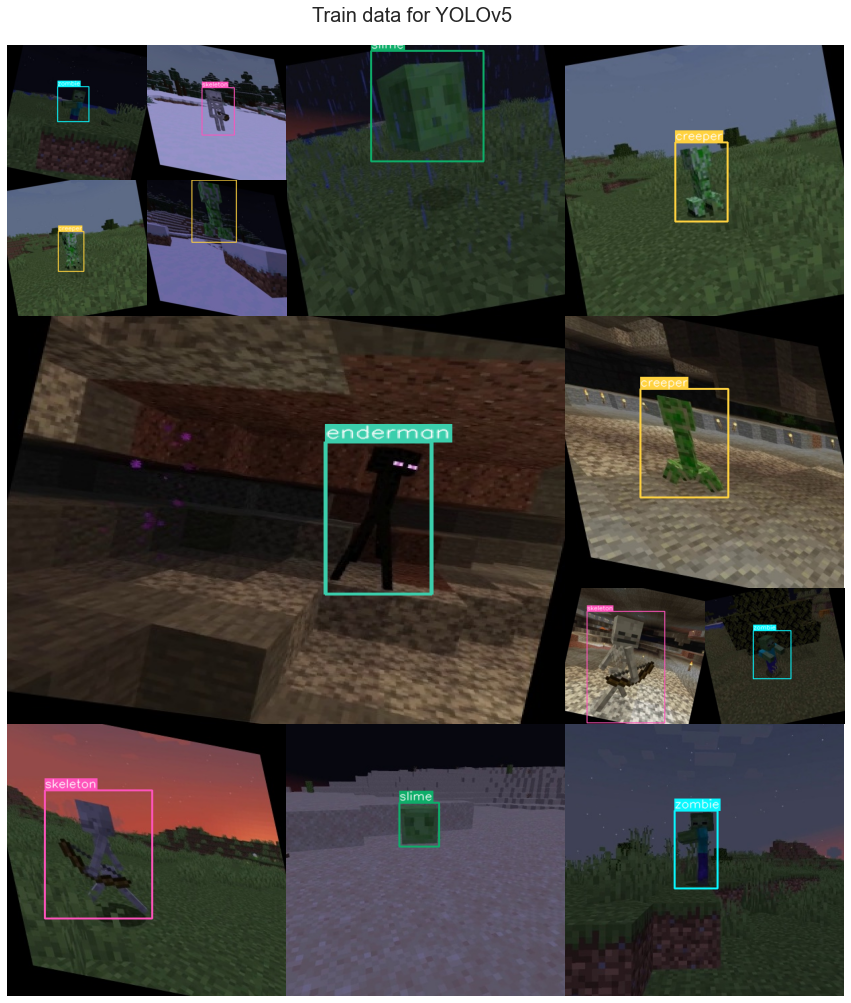

In [96]:
yolo_images_sample = sorted((DIST_LABELS_YOLO / 'train' / 'images').iterdir())
yolo_labels_sample = sorted((DIST_LABELS_YOLO / 'train' / 'labels').iterdir())
yolo_mobs_sample = [f.name.split('_')[1] for f in yolo_images_sample]

yolo_sample = RANDOM.choice(
    list(zip(yolo_images_sample, yolo_labels_sample, yolo_mobs_sample)),
    size=MOSAIC_13.nimages,
    replace=False
)

yolo_sample_plot = []
for i, (img_path, label_path, mob) in enumerate(yolo_sample):
    img = utils.Image.open(img_path)
    label = utils.Label.open(label_path)
    yolo_sample_plot.append(utils.visualize_bbox(img.data, label.bbox, mob, color=COLOR_PALETTE.get(mob)))

MOSAIC_13.plot(yolo_sample_plot, fig_width=15, title_kwargs={'title': 'Train data for YOLOv5', 'y': 0.91})

del yolo_sample_plot

## Обучение модели в Google Colab

In [159]:
# 01_colab.ipynb - код для запуска в colab

## Разметка данных с помощью предобученной модели

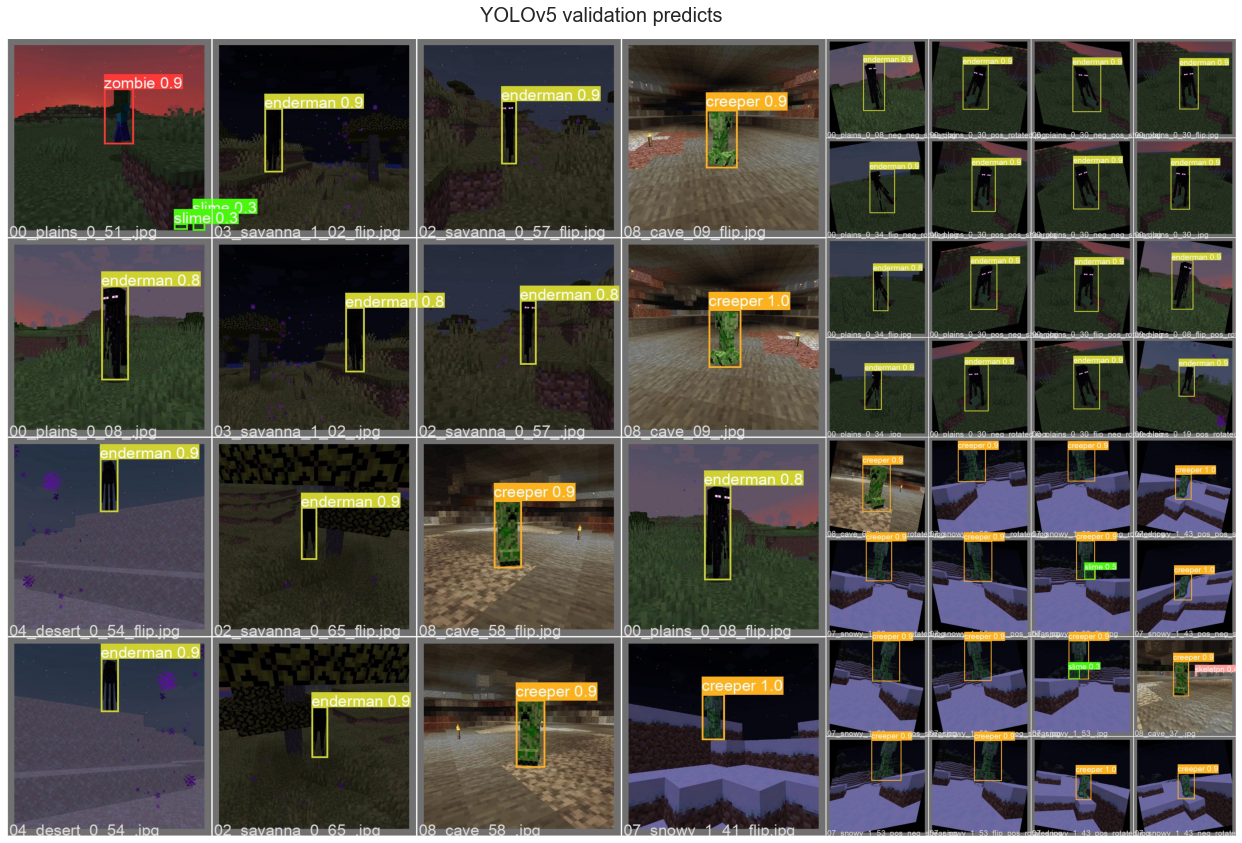

In [97]:
predict_batches = list((DIST_MODELS / 'yolov5/labeler/runs/train/exp').glob('val_batch?_pred.jpg'))
predict_plot = [utils.Image.open(i).data for i in predict_batches]

MOSAIC_3.plot(predict_plot, fig_width=22, title_kwargs={'title': 'YOLOv5 validation predicts', 'y': 0.91})

del predict_plot

In [80]:
import yolov5
from yolov5.models.common import Detections, AutoShape

In [84]:
def yolo_labeling(yolo: AutoShape, images_dir: Path, labels_dir: Path) -> list[str]:
    problems = []

    batch = 200
    images = list(images_dir.iterdir())
    for i in tqdm(range(0, len(images) + 1, batch)):
        detects: Detections = yolo(images[i:i + batch], size=IMG_SIZE_YOLO)
        for detection, fname in zip(detects.xywhn, detects.files):
            mob_idx = MOBS.index(fname.split('_')[1])
            detection = detection[detection[:, -1] == mob_idx]
            if len(detection):
                detection = detection[detection[:, -2].argsort(descending=True)]
                *bbox, _, cls = detection[0]
                label = utils.Label(int(cls), utils.BBox(*map(float, bbox)))
                label.save(labels_dir / Path(fname).with_suffix('.txt'))
            else:
                problems.append(fname)
                with open(labels_dir / Path(fname).with_suffix('.txt'), 'w'):
                    pass

    with open(labels_dir / 'classes.txt', 'w') as f:
        f.write('\n'.join(MOBS))

    return problems


In [85]:
yolo = yolov5.load(DIST_MODELS / 'yolov5/labeler/runs/train/exp/weights/best.pt')

In [86]:
problems = yolo_labeling(yolo, DATA_IMAGES_YOLO, DATA_LABELS)
problems

  0%|          | 0/19 [00:00<?, ?it/s]

['00_zombie_03_savanna_1_12.jpg',
 '02_spider_01_plains_1_00.jpg',
 '02_spider_01_plains_1_04.jpg',
 '02_spider_01_plains_1_05.jpg',
 '02_spider_01_plains_1_53.jpg',
 '02_spider_01_plains_1_63.jpg',
 '02_spider_02_savanna_0_44.jpg',
 '02_spider_02_savanna_0_69.jpg',
 '02_spider_02_savanna_0_70.jpg',
 '02_spider_06_snowy_0_28.jpg',
 '02_spider_07_snowy_1_63.jpg',
 '02_spider_07_snowy_1_64.jpg',
 '03_creeper_02_savanna_0_69.jpg',
 '04_enderman_02_savanna_0_68.jpg',
 '04_enderman_05_desert_1_18.jpg']

In [5]:
problems = [
    '00_zombie_03_savanna_1_12.jpg',
    '02_spider_01_plains_1_00.jpg',
    '02_spider_01_plains_1_04.jpg',
    '02_spider_01_plains_1_05.jpg',
    '02_spider_01_plains_1_53.jpg',
    '02_spider_01_plains_1_63.jpg',
    '02_spider_02_savanna_0_44.jpg',
    '02_spider_02_savanna_0_69.jpg',
    '02_spider_02_savanna_0_70.jpg',
    '02_spider_06_snowy_0_28.jpg',
    '02_spider_07_snowy_1_63.jpg',
    '02_spider_07_snowy_1_64.jpg',
    '03_creeper_02_savanna_0_69.jpg',
    '04_enderman_02_savanna_0_68.jpg',
    '04_enderman_05_desert_1_18.jpg',
]

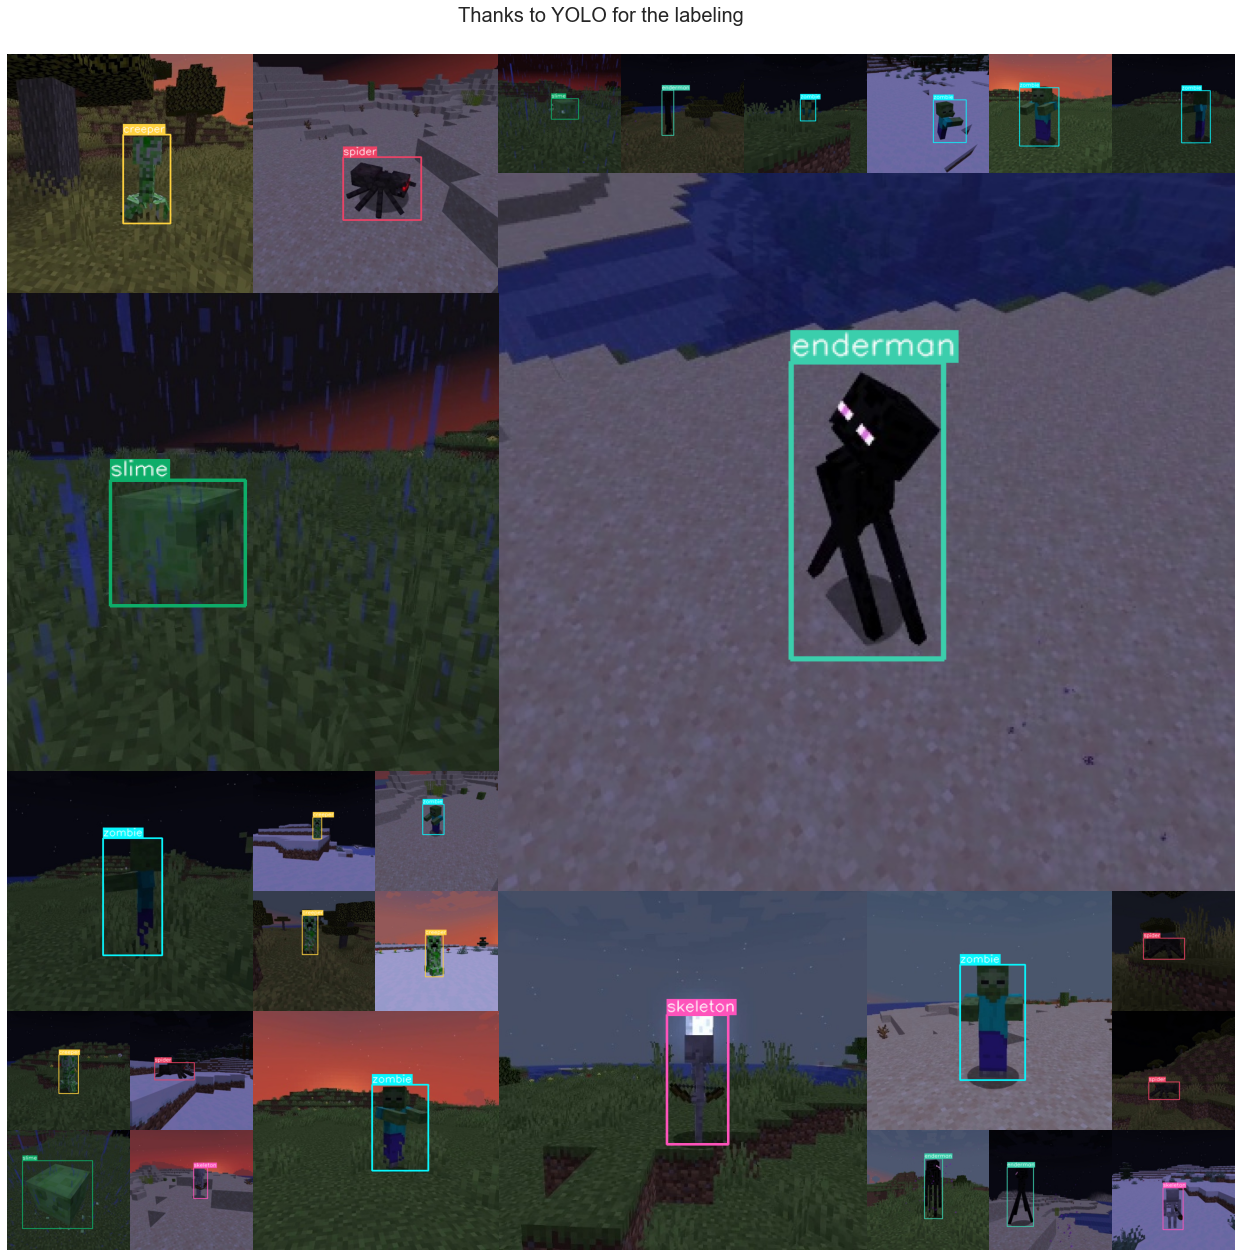

In [98]:
images_sample = sorted(DATA_IMAGES_YOLO.iterdir())
labels_sample = sorted(DATA_LABELS.iterdir())
mobs_sample = [f.name.split('_')[1] for f in images_sample]

sample = RANDOM.choice(
    list(zip(images_sample, labels_sample, mobs_sample)),
    size=MOSAIC_27.nimages,
    replace=False
)

sample_plot = []
for i, (img_path, label_path, mob) in enumerate(sample):
    img = utils.Image.open(img_path)
    label = utils.Label.open(label_path)
    sample_plot.append(utils.visualize_bbox(img.data, label.bbox, mob, color=COLOR_PALETTE.get(mob)))

MOSAIC_27.plot(sample_plot, fig_width=22, title_kwargs={'title': 'Thanks to YOLO for the labeling', 'y': 0.91})

del sample_plot

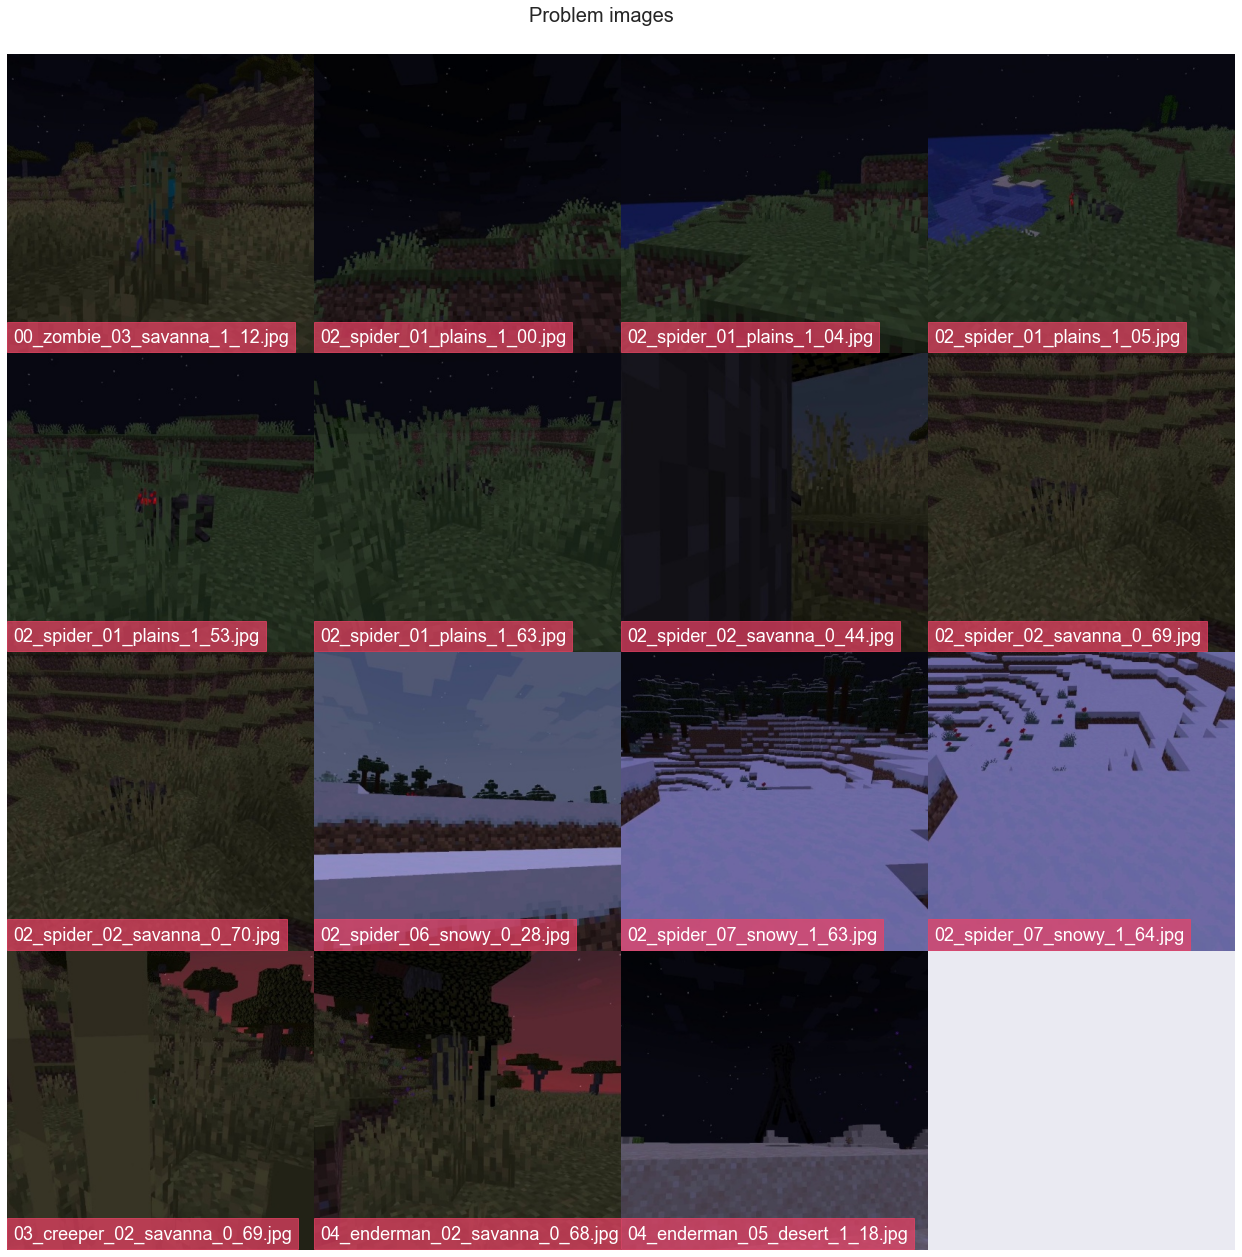

In [99]:
problem_images = [
    utils.Image.open(DATA_IMAGES_YOLO / p).data
    for p in problems
]

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, 22 / (ncols / nrows)))
fig.subplots_adjust(hspace=0.00, wspace=0.00)
fig.suptitle('Problem images', y=0.91)
for i, image in enumerate(problem_images):
    row = i // ncols
    col = i % ncols
    ax: Axes = axes[row, col]
    utils.reset_axes(ax)
    ax.set_title(problems[i], loc='left', y=0.018, fontdict={
        'color': 'white',
        'backgroundcolor': [*[i / 255 for i in COLOR_PALETTE.get(MOBS[2])], 0.7],
        'size': 18,
        'x': 0.02
    })

    ax.imshow(image, aspect='auto')

utils.reset_axes(axes[3, 3])

del problem_images

# Задача классификации

In [102]:
# https://blog.roboflow.com/you-might-be-resizing-your-images-incorrectly/#how-should-i-fill-padding-pixels
# https://forums.fast.ai/t/partial-convergence-padding-vs-reflection-zero-etc/43508

cropped_images = []

for img_path, label_path in zip(DATA_IMAGES_ORIG.iterdir(), DATA_LABELS.iterdir()):
    if img_path.name not in problems:
        img = utils.Image.open(img_path)
        label = utils.Label.open(label_path)
        cropped_images.append((utils.crop_bbox_rect(img.data, label.bbox), label))

In [103]:
sorted_images = sorted(cropped_images, key=lambda x: x[0].shape[0])


In [107]:
cv2.imshow('', sorted_images[0][0])
cv2.waitKey()

-1

In [9]:
img = utils.Image.open(DATA_IMAGES_ORIG / '02_spider_01_plains_1_03.jpg')
label = utils.Label.open(DATA_LABELS / '02_spider_01_plains_1_03.txt')

_, _, w, h = label.bbox.xywh(*utils.get_wh(img.data))

In [10]:
max(w, h)

51.383268000000044